# STEP 1 - PARSING DOCUMENT USING IBM DocLing LIBRARY

In [1]:
import os
from pathlib import Path
from tempfile import mkdtemp
from warnings import filterwarnings
from rich.pretty import pprint
from dotenv import load_dotenv

import time
import copy
from typing import List
import pandas as pd
from pathlib import Path
from typing import Tuple
import base64
from pydantic import BaseModel
# from io import BytesIO
# import cv2
from matplotlib import pyplot as plt
import numpy as np
from pydantic import TypeAdapter

import requests

import PyPDF2
from pdf2image import convert_from_bytes
from IPython.display import display, Markdown, HTML, display_html
from PIL import Image, ImageDraw

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI

# from llama_index.core import StorageContext, VectorStoreIndex
# from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.readers.docling import DoclingReader

from llama_index.node_parser.docling import DoclingNodeParser
from llama_index.core import Document as LIDocument

from docling.datamodel.base_models import ConversionStatus
from docling.datamodel.document import ConversionResult
from docling.datamodel.settings import settings



from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.models.ocr_mac_model import OcrMacOptions
from docling.models.tesseract_ocr_cli_model import TesseractCliOcrOptions
#from docling.models.tesseract_ocr_model import TesseractOcrOptions
from docling.datamodel.pipeline_options import (
    EasyOcrOptions,
    OcrMacOptions,
    PdfPipelineOptions,
    RapidOcrOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
    AcceleratorDevice,
    AcceleratorOptions,
)

from docling.datamodel.settings import settings

#from docling.backend.docling_parse_backend import DoclingParseDocumentBackend



/Users/gurvindersingh/Documents/development/learning/watsonx-workshop/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import logging
import time
from pathlib import Path
from typing import Iterable

def _get_env_from_colab_or_os(key):
    try:
        from google.colab import userdata

        try:
            return userdata.get(key)
        except userdata.SecretNotFoundError:
            pass
    except ImportError:
        pass
    return os.getenv(key)

load_dotenv()

_log = logging.getLogger(__name__)

filterwarnings(action="ignore", category=UserWarning, module="pydantic")
filterwarnings(action="ignore", category=FutureWarning, module="easyocr")
# https://github.com/huggingface/transformers/issues/5486:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

OUTPUT_DIR = Path("../results/extract")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


#### PLEASE PROVIDE THE PATH OF SOURCE DOCUMENT
# SOURCE = "/Users/gurvindersingh/Library/CloudStorage/Box-Box/MyDocs/2024/GSIs/NTTData/BoI/docs/input_output/FinancialReport1.pdf"
SOURCE = "./pdfs/US_Visa_FAQ.pdf"



# STEP 1 - Load and Parse Documents

In [3]:
import yaml

## SAVING THE DOCUMENTS AS PARQUET FILE.  THIS CAN BE USED FOR FURTHER ANALYTICS OR OTHER SHOWING DETAILS ON THE UI
def export_documents(
    conv_results: Iterable[ConversionResult],
    output_dir: Path,
):
    output_dir.mkdir(parents=True, exist_ok=True)

    success_count = 0
    failure_count = 0
    partial_success_count = 0

    for conv_res in conv_results:
        if conv_res.status == ConversionStatus.SUCCESS:
            success_count += 1
            doc_filename = conv_res.input.file.stem

            # Export Docling document format to JSON:
            with (output_dir / f"{doc_filename}.json").open("w") as fp:
                dl_dict = conv_res.document.export_to_dict()
                jsonObj = json.dumps(dl_dict)
                fp.write(jsonObj)

            # jsonStr = dl_doc.model_dump_json()
            # jsonObj = json.loads(jsonStr)
            df = pd.DataFrame.from_dict([jsonObj])
            # df.head()    
            parquet_file_path = OUTPUT_DIR / f"{doc_filename}.parquet"
            df.to_parquet(parquet_file_path)

            # # Export Docling document format to YAML:
            # with (output_dir / f"{doc_filename}.yaml").open("w") as fp:
            #     fp.write(yaml.safe_dump(conv_res.document.export_to_dict()))

            # # Export Docling document format to doctags:
            # with (output_dir / f"{doc_filename}.doctags.txt").open("w") as fp:
            #     fp.write(conv_res.document.export_to_document_tokens())

            # # Export Docling document format to markdown:
            # with (output_dir / f"{doc_filename}.md").open("w") as fp:
            #     fp.write(conv_res.document.export_to_markdown())

            # # Export Docling document format to text:
            # with (output_dir / f"{doc_filename}.txt").open("w") as fp:
            #     fp.write(conv_res.document.export_to_markdown(strict_text=True))

        elif conv_res.status == ConversionStatus.PARTIAL_SUCCESS:
            _log.info(
                f"Document {conv_res.input.file} was partially converted with the following errors:"
            )
            for item in conv_res.errors:
                _log.info(f"\t{item.error_message}")
            partial_success_count += 1
        else:
            _log.info(f"Document {conv_res.input.file} failed to convert.")
            failure_count += 1

    _log.info(
        f"Processed {success_count + partial_success_count + failure_count} docs, "
        f"of which {failure_count} failed "
        f"and {partial_success_count} were partially converted."
    )
    return success_count, partial_success_count, failure_count

# pprint(docs, max_length=1, max_string=50, max_depth=4)

In [4]:
def main():
    logging.basicConfig(level=logging.INFO)

    input_doc_paths = [
        Path(SOURCE)       
    ]

    # buf = BytesIO(Path("./test/data/2206.01062.pdf").open("rb").read())
    # docs = [DocumentStream(name="my_doc.pdf", stream=buf)]
    # input = DocumentConversionInput.from_streams(docs)

    # Explicitly set the accelerator
    accelerator_options = AcceleratorOptions(
        num_threads=8, device=AcceleratorDevice.AUTO
    )
    # accelerator_options = AcceleratorOptions(
    #     num_threads=8, device=AcceleratorDevice.CPU
    # )
    # accelerator_options = AcceleratorOptions(
    #     num_threads=8, device=AcceleratorDevice.MPS
    # )
    # accelerator_options = AcceleratorOptions(
    #     num_threads=8, device=AcceleratorDevice.CUDA
    # )

    pipeline_options = PdfPipelineOptions()
    pipeline_options.accelerator_options = accelerator_options
    pipeline_options.do_ocr = False
    # pipeline_options.images_scale = 1.0
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = True
    pipeline_options.table_structure_options.mode = TableFormerMode.FAST 
    # pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model

    # OCR_options = [EasyOcrOptions, TesseractCliOcrOptions, OcrMacOptions, RapidOcrOptions]

    ocr_options = EasyOcrOptions(force_full_page_ocr=True, confidence_threshold=0.1)
    # ocr_options = OcrMacOptions(force_full_page_ocr=True)
    # ocr_options = TesseractCliOcrOptions(force_full_page_ocr=True)
    # ocr_options = RapidOcrOptions(force_full_page_ocr=True)
    pipeline_options.ocr_options = ocr_options

    # Enable the profiling to measure the time spent
    # settings.debug.profile_pipeline_timings = True
    # # Turn on inline debug visualizations:
    # settings.debug.visualize_layout = True
    # settings.debug.visualize_ocr = True
    # settings.debug.visualize_tables = True
    # settings.debug.visualize_cells = True
    
    doc_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )

    # doc_converter: DocumentConverter = Field(default_factory=DocumentConverter)
    # reader = DoclingReader(export_type=DoclingReader.ExportType.JSON, doc_converter=doc_converter)
    # doc_converter = DocumentConverter()

    start_time = time.time()

    conv_results = doc_converter.convert_all(
        input_doc_paths,
        raises_on_error=False,  # to let conversion run through all and examine results at the end
    )
    success_count, partial_success_count, failure_count = export_documents(
        conv_results, output_dir=Path("scratch")
    )

    end_time = time.time() - start_time

    _log.info(f"Document conversion complete in {end_time:.2f} seconds.")

    if failure_count > 0:
        raise RuntimeError(
            f"The example failed converting {failure_count} on {len(input_doc_paths)}."
        )

In [5]:
if __name__ == "__main__":
    main()

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document US_Visa_FAQ.pdf
INFO:docling.document_converter:Finished converting document US_Visa_FAQ.pdf in 17.64 sec.
INFO:__main__:Processed 1 docs, of which 0 failed and 0 were partially converted.
INFO:__main__:Document conversion complete in 17.68 seconds.


In [6]:
import os
import pathlib
from docling_core.types.doc.document import DoclingDocument as DLDocument

def read_parquet(file_path):
    document_content_df = pd.read_parquet(file_path)
    tempStr: str = document_content_df.to_json(orient='records')
    tempObj = json.loads(tempStr)
    jsonString = json.dumps(tempObj[0]["0"])
    jsonObj = json.loads(jsonString)
    # print(jsonObj)
    # pprint(jsonObj, max_length=5, max_string=50, max_depth=4)       
    dl_output: DLDocument = DLDocument.model_validate_json(jsonObj)    
    return dl_output

# file_name = "PRINTER_cpd58007"
collection_name = os.path.basename(SOURCE).split('/')[-1].split('.')[0]
parquet_file_path = OUTPUT_DIR / f"{collection_name}.parquet"
dl_obj = read_parquet(parquet_file_path)
# print(f"\n\n{dl_obj.export_to_markdown()}\n\n")
# pprint(dl_obj, max_length=10, max_string=50, max_depth=4)

# SHOW bbox for Each Element

In [7]:
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import copy

from docling_core.types.doc.document import (
    DocItem,
    DocumentOrigin,
    LevelNumber,
    ListItem,
    SectionHeaderItem,
    TableItem,
    TextItem,
    PictureItem
)
from docling_core.types.doc.labels import DocItemLabel
from docling_core.types.doc.base import (
    CoordOrigin,
    Size,
    BoundingBox
)

IMAGE_RESOLUTION_SCALE = 2.0

def convert_to_image(pdf_path, page_num):
    pdf_file = open(pdf_path, 'rb')
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    page = pdf_reader.pages[page_num]
   
    pdf_writer = PyPDF2.PdfWriter()
    pdf_writer.add_page(page)

    buffer = io.BytesIO()
    pdf_writer.write(buffer)
    
    # Convert output PDF data to image and save as PNG file
    images = convert_from_bytes(buffer.getvalue())
    buffer.close()    
    pdf_file.close()
    
    return images[0]

def crop_image_from_pdf(page_image, page_size: Size, crop_coords):
    """Crops an image from a PDF page."""
    # page_image = convert_to_image(pdf_path, page_num)
    page_image = page_image.resize((int(page_size.width), int(page_size.height)))
    cropped_im = page_image.crop(crop_coords.as_tuple())
    return cropped_im

def convert_to_pil_image(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    pil_img = copy.deepcopy(Image.open(buf))   
    buf.close()
    return pil_img

def convert_to_img_bytes(pil_img):
    img_byte_arr = io.BytesIO()
    pil_img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr
    

In [8]:
page = dl_obj.pages[7]
pprint(page, max_length=5, max_string=50, max_depth=4)

PageItem(size=Size(width=595.25, height=842.0), image=None, page_no=7)

[
│   {
│   │   'page_no': 11,
│   │   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1190x1684 at 0x3370984D0>,
│   │   'figsize': (11.905, 16.84)
│   },
│   {
│   │   'page_no': 11,
│   │   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1190x1684 at 0x33B880ED0>,
│   │   'figsize': (11.905, 16.84)
│   },
│   {
│   │   'page_no': 11,
│   │   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1190x1684 at 0x16FAA6050>,
│   │   'figsize': (11.905, 16.84)
│   },
│   {
│   │   'page_no': 11,
│   │   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1190x1684 at 0x3A71F6FD0>,
│   │   'figsize': (11.905, 16.84)
│   },
│   {
│   │   'page_no': 11,
│   │   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1190x1684 at 0x3A4C61950>,
│   │   'figsize': (11.905, 16.84)
│   },
│   ... +4
]

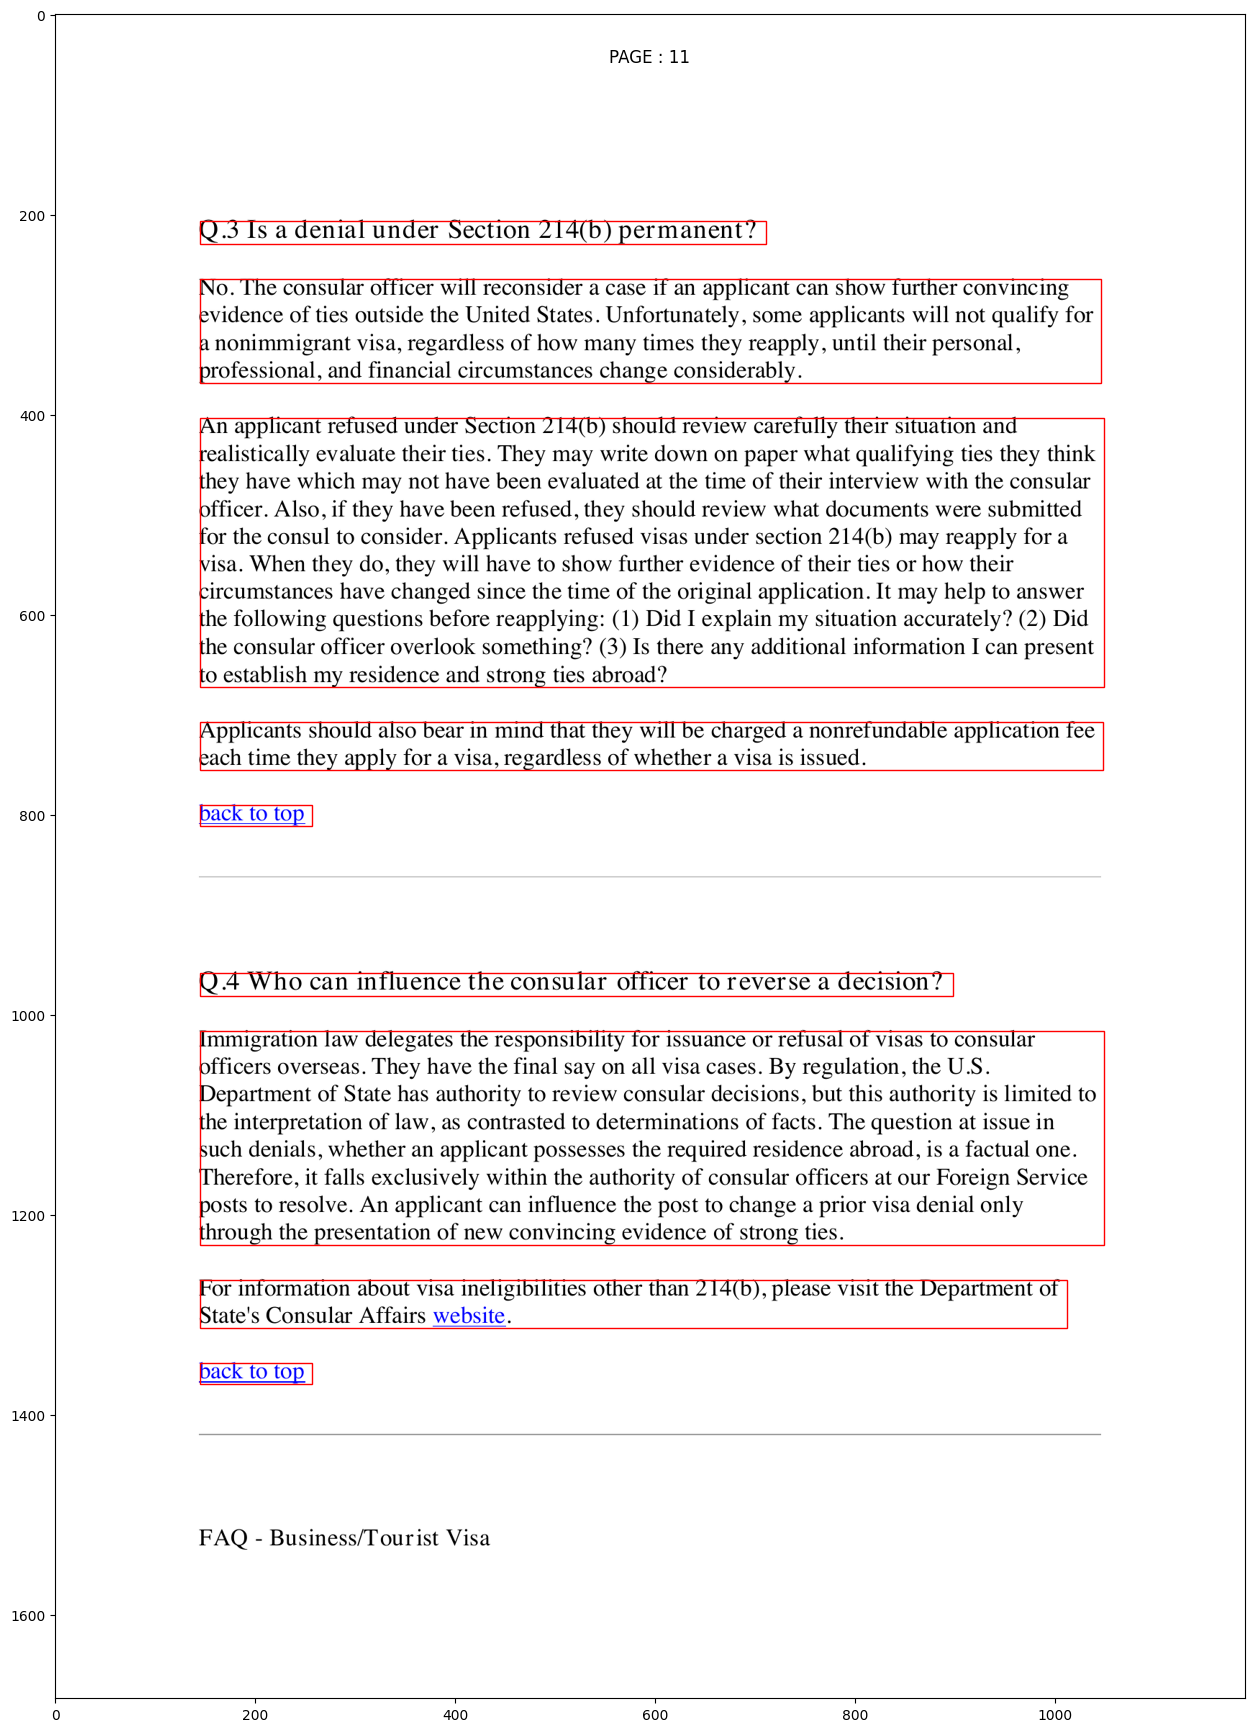

In [9]:


# page_range = range(3, 5)

# for element, _level in dl_obj.iterate_items():
#     # if isinstance(element, PictureItem):
#     #     pprint(element, max_length=5, max_string=50, max_depth=4)
#     #     if element.image is not None:
#     #         display(element.image.pil_image)
    
#     if element.prov is not None and len(element.prov) > 0:
#         if isinstance(element, PictureItem) == True and element.prov[0].page_no in page_range:
#             pprint(element.prov[0], max_length=5, max_string=50, max_depth=4)
            
def mark_nodes(pdf_file_path, dl_obj, page_range):
    page_no = None
    page = None
    page_image = None
    images = []    
    pil_img = None
    
    for element, _level in dl_obj.iterate_items():
        # if isinstance(element, TableItem) == False:
        #     continue
            
        if element.prov[0].page_no in page_range:
            page = dl_obj.pages[element.prov[0].page_no]
            if page_no != page.page_no: 
                page_no = page.page_no
               
                page_image = convert_to_image(pdf_file_path, (page.page_no - 1))
                page.size.width = page.size.width * IMAGE_RESOLUTION_SCALE
                page.size.height = page.size.height * IMAGE_RESOLUTION_SCALE
                page_image = page_image.resize((int(page.size.width), int(page.size.height)))
                dpi = 100
                # Convert pixels to inches
                width_in = page.size.width / dpi
                height_in = page.size.height / dpi
                # plt.imshow(page_image)
                # fig, ax = plt.subplots(figsize=(width_in, height_in)) 
                fig = plt.figure(figsize=(width_in, height_in))
                fig.suptitle(f"PAGE : {page.page_no}")
                ax = fig.add_axes([0,0,1,1]) 
                # print(f"PAGE: {page.page_no}")
                img = plt.imshow(page_image)
                # pil_img = convert_to_pil_image(plt)
                # images.append({"page_no": page.page_no, "image": pil_img, "figsize": (width_in, height_in)})                
                
               
            bbox = BoundingBox.from_tuple(element.prov[0].bbox.as_tuple(), origin=CoordOrigin.TOPLEFT)
            bbox1 = bbox.scaled(IMAGE_RESOLUTION_SCALE)
            bbox2 = bbox1.to_bottom_left_origin(page_height=page.size.height)
           
            tx = bbox2.l
            ty = bbox2.b
            tw = bbox2.width
            th = bbox2.height
    
            edgecolor = 'r'    
            rect = patches.Rectangle((tx, ty), tw, th, linewidth=1, edgecolor=edgecolor, facecolor='none')
            ax.add_patch(rect) 

            # for cell in element.data.table_cells:
            #     # pprint(cell, max_length=5, max_string=50, max_depth=4)
            #     if cell.bbox is not None:
            #         bbox = BoundingBox.from_tuple(cell.bbox.as_tuple(), origin=CoordOrigin.TOPLEFT)
            #         bbox1 = bbox.scaled(IMAGE_RESOLUTION_SCALE)
            #         bbox2 = bbox1.to_bottom_left_origin(page_height=page.size.height)
                   
            #         x = bbox2.l
            #         y = bbox2.b
            #         w = bbox2.width
            #         h = bbox2.height
            
            #         edgecolor = 'blue'    
            #         rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
            #         ax.add_patch(rect)
            
            # for ix, grid in enumerate(element.data.grid):
            #     # print(f"{ix}) ")    
            #     first_cell_found = False
            #     for iy, g in enumerate(grid):
            #         # pprint(g, max_length=5, max_string=50, max_depth=4)                    
            #         if first_cell_found == False and g.bbox is not None:
            #             first_cell_found = True
            #             bbox = BoundingBox.from_tuple(g.bbox.as_tuple(), origin=CoordOrigin.TOPLEFT)
            #             bbox1 = bbox.scaled(IMAGE_RESOLUTION_SCALE)
            #             bbox2 = bbox1.to_bottom_left_origin(page_height=page.size.height)
                       
            #             x = bbox2.l
            #             y = bbox2.b
            #             w = bbox2.width
            #             h = bbox2.height

            #             if ix % 2:
            #                 edgecolor = 'blue'  
            #             else:
            #                 edgecolor = 'green'
            #             rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
            #             ax.add_patch(rect)

            if 'data' in element:
                for ix, grid in enumerate(element.data.grid):
                    first_cell_found = False
                    for iy, g in enumerate(grid):
                        # pprint(g, max_length=5, max_string=50, max_depth=4)                    
                        if first_cell_found == False and g.bbox is not None:
                            first_cell_found = True
                            bbox = BoundingBox.from_tuple(g.bbox.as_tuple(), origin=CoordOrigin.TOPLEFT)
                            bbox1 = bbox.scaled(IMAGE_RESOLUTION_SCALE)
                            bbox2 = bbox1.to_bottom_left_origin(page_height=page.size.height)
                           
                            x = tx - 1
                            y = bbox2.b - 5
                            w = tw 
                            h = bbox2.height + 8
    
                            if ix % 2:
                                edgecolor = 'blue'  
                            else:
                                edgecolor = 'green'
                            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
                            ax.add_patch(rect)
            
            # plt.savefig(os.path.join('../results', f"Table_{page_no}_bbox.png"))
            pil_img = convert_to_pil_image(plt)            
            images.append({"page_no": page.page_no, "image": pil_img, "figsize": (width_in, height_in)})         
            
        else:
            continue
            
    # pil_img = convert_to_pil_image(plt)
    # # pprint(page, max_length=5, max_string=50, max_depth=4)
    # print(f"LAST PAGE: {page.page_no}")
    # plt.imshow(page_image)    
    # images.append({"page_no": page.page_no, "image": page_image})
        # images.append({"page_no": page.page_no, "image": plt, "figsize": (width_in, height_in)})         
        
        

    return images

pdf_file_path = SOURCE
copied_dl_obj = copy.deepcopy(dl_obj)

pages_to_show = range(11, 12)

images = mark_nodes(pdf_file_path, copied_dl_obj, pages_to_show)

pprint(images, max_length=5, max_string=50, max_depth=4)
# plt.savefig('my_plot1.png') 
# display(images[0]['image'])

# images[0]['image'].savefig(os.path.join('../results', f"Table0_bbox.png"))
# images[1]['image'].savefig(os.path.join('../results', f"Table1_bbox.png"))
            